- NVIDIA GeForce GTX 1060 6GB
- Pytorch 1.4.0
- model EfficientNet-B3
- image size 128x128
- batch size 64
- 0-folds
- 10 epochs
- no augmentation
- optimizer over 9000
- one cycle learning rate

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import gc
import cv2
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import warnings
warnings.filterwarnings("ignore")

from crop_resize import read_feathers

In [2]:
model_name = 'efficientnet-b3'
image_size = 128
batch_size = 64
random_state = 2020
n_epochs = 30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

in_dir = Path('../input/bengaliai-cv19')
feather_dir = Path('../input/bengaliai-cv19-feather')
out_dir = Path('./20200308_fold0_no_aug_0-1')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 2020
seed_everything(SEED)

<a id="images"></a>
# Images

In [4]:
filenames = [feather_dir/f'train_image_data_1x{image_size}x{image_size}_{i}.feather' for i in range(4)]
images = read_feathers(filenames, image_size)
print(images.shape)

(200840, 128, 128)


<a id="labels"></a>
# Labels

In [5]:
train_label = pd.read_csv(in_dir/'train.csv')
labels = train_label[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
print(labels.shape)

(200840, 3)


<a id="dataset"></a>
# Dataset

In [6]:
from torch.utils.data import Dataset

class GraphemeDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.train = labels is not None
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = image / image.max()
        if self.transform:
            image = self.transform(image)
        if self.train:
            label = self.labels[idx]
            return image, label[0], label[1], label[2]
        else:
            return image

In [7]:
train_dataset = GraphemeDataset(images, labels)
print(len(train_dataset))

200840


<a id="visualize"></a>
# Visualize

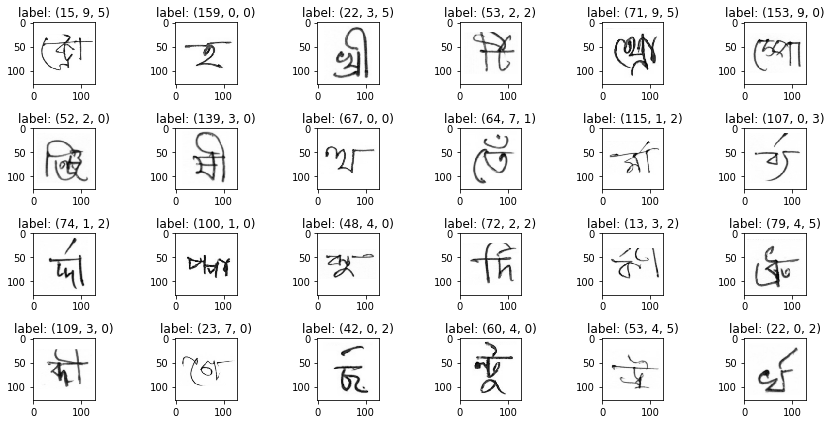

In [8]:
nrow, ncol = 4, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, label1, label2, label3 = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label1, label2, label3}')
plt.tight_layout()
plt.show()

<a id="dataloader"></a>
# DataLoader

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('train loader length', len(train_loader))

train loader length 3139


<a id="model"></a> 
# Model

In [11]:
from my_efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained(model_name, in_channels=1).to(device)

cuda:0
Loaded pretrained weights for efficientnet-b3


<a id="optimizer"></a> 
# Optimizer

In [12]:
from optimizer.ralamb import Ralamb
from optimizer.lookahead import Lookahead

def Over9000(params, alpha=0.5, k=6, *args, **kwargs):
     ralamb = Ralamb(params, *args, **kwargs)
     return Lookahead(ralamb, alpha, k)

In [13]:
optimizer =Over9000(model.parameters(), lr=2e-3, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=None, epochs=n_epochs, 
                                                steps_per_epoch=len(train_loader), pct_start=0.0, anneal_strategy='cos', 
                                                cycle_momentum=True, base_momentum=0.85, max_momentum=0.95,  div_factor=100.0)

<a id="loss"></a> 
# loss

In [14]:
from torch import nn

criterion = nn.CrossEntropyLoss()

<a id="metrics"></a> 
# Metrics

In [15]:
from metrics import macro_recall_multi

<a id="train"></a> 
# Train

In [16]:
history = pd.DataFrame()

for epoch in range(n_epochs):
    
    # --- training start ---
    torch.cuda.empty_cache()
    gc.collect()
    
    running_loss1, running_loss2, running_loss3 = 0.0, 0.0, 0.0
    running_acc1, running_acc2, running_acc3 = 0.0, 0.0, 0.0
    running_recall = 0.0
    
    train_loss1, train_loss2, train_loss3 = 0.0, 0.0, 0.0
    train_acc1, train_acc2, train_acc3 = 0.0, 0.0, 0.0
    train_loss, train_acc, train_recall = 0.0, 0.0, 0.0
    
    model.train()
    
    # training loop
    for idx, (inputs, labels1, labels2, labels3) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # to GPU
        inputs, labels1, labels2, labels3 = inputs.to(device), labels1.to(device), labels2.to(device), labels3.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward (on GPU)
        outputs1, outputs2, outputs3 = model(inputs.unsqueeze(1).float())
        #outputs1, outputs2, outputs3 = model(inputs.float())
        
        # loss
        loss1 = criterion(outputs1, labels1)
        loss2 = criterion(outputs2, labels2)
        loss3 = criterion(outputs3, labels3)
        running_loss1 += loss1.item()
        running_loss2 += loss2.item()
        running_loss3 += loss3.item()
        
        # accuracy
        running_acc1 += (outputs1.argmax(1)==labels1).float().mean()
        running_acc2 += (outputs2.argmax(1)==labels2).float().mean()
        running_acc3 += (outputs3.argmax(1)==labels3).float().mean()
        
        # recall
        running_recall += macro_recall_multi(outputs1, labels1, outputs2, labels2, outputs3, labels3)
        
        # backward (on GPU)
        (0.8 * loss1 + 0.1 * loss2 + 0.1 * loss3).backward()
        
        # optimize
        optimizer.step()
        scheduler.step()
    
    # loss, accuracy, recall
    train_loss1 = running_loss1 / len(train_loader)
    train_loss2 = running_loss2 / len(train_loader)
    train_loss3 = running_loss3 / len(train_loader)
    train_loss = 0.5 * train_loss1 + 0.25 * train_loss2 + 0.25 * train_loss3
    train_acc1 = running_acc1 / len(train_loader)
    train_acc2 = running_acc2 / len(train_loader)
    train_acc3 = running_acc3 / len(train_loader)
    train_acc = (train_acc1 + train_acc2 + train_acc3) / 3
    train_recall = running_recall / len(train_loader)
    
    # log
    print('train epoch : {}'.format(epoch))
    print('loss   : {:.4f}, loss1 : {:.4f}, loss2 : {:.4f}, loss3 : {:.4f}'.format(train_loss, train_loss1, train_loss2, train_loss3))
    print('acc    : {:.4f}, acc1  : {:.4f}, acc2  : {:.4f}, acc3  : {:.4f}'.format(train_acc, train_acc1, train_acc2, train_acc3))
    print('recall : {:.4f}'.format(train_recall))
    
    # history
    history.loc[epoch, 'train/loss'] = train_loss
    history.loc[epoch, 'train/loss1'] = train_loss1
    history.loc[epoch, 'train/loss2'] = train_loss2
    history.loc[epoch, 'train/loss3'] = train_loss3
    history.loc[epoch, 'train/acc'] = train_acc.cpu().numpy()
    history.loc[epoch, 'train/acc1'] = train_acc1.cpu().numpy()
    history.loc[epoch, 'train/acc2'] = train_acc2.cpu().numpy()
    history.loc[epoch, 'train/acc3'] = train_acc3.cpu().numpy()
    history.loc[epoch, 'train/recall'] = train_recall
    history.loc[epoch, 'lr'] = scheduler.get_lr()[0]
    
    torch.save(model.state_dict(), out_dir/f'{model_name}_{epoch}.pth')

history.to_csv(out_dir/'history.csv')


train epoch : 0
loss   : 0.5738, loss1 : 0.7964, loss2 : 0.4029, loss3 : 0.2996
acc    : 0.8539, acc1  : 0.7886, acc2  : 0.8680, acc3  : 0.9050
recall : 0.7635



train epoch : 1
loss   : 0.2491, loss1 : 0.3419, loss2 : 0.1606, loss3 : 0.1521
acc    : 0.9364, acc1  : 0.9008, acc2  : 0.9537, acc3  : 0.9548
recall : 0.8834



train epoch : 2
loss   : 0.1905, loss1 : 0.2570, loss2 : 0.1260, loss3 : 0.1221
acc    : 0.9510, acc1  : 0.9242, acc2  : 0.9647, acc3  : 0.9643
recall : 0.9093



train epoch : 3
loss   : 0.1539, loss1 : 0.2030, loss2 : 0.1076, loss3 : 0.1019
acc    : 0.9598, acc1  : 0.9393, acc2  : 0.9699, acc3  : 0.9703
recall : 0.9252



train epoch : 4
loss   : 0.1277, loss1 : 0.1643, loss2 : 0.0924, loss3 : 0.0899
acc    : 0.9663, acc1  : 0.9505, acc2  : 0.9747, acc3  : 0.9737
recall : 0.9375



train epoch : 5
loss   : 0.1099, loss1 : 0.1372, loss2 : 0.0837, loss3 : 0.0815
acc    : 0.9706, acc1  : 0.9581, acc2  : 0.9774, acc3  : 0.9762
recall : 0.9455



train epoch : 6
loss   : 0.0945, loss1 : 0.1143, loss2 : 0.0756, loss3 : 0.0738
acc    : 0.9739, acc1  : 0.9639, acc2  : 0.9792, acc3  : 0.9787
recall : 0.9524



train epoch : 7
loss   : 0.0821, loss1 : 0.0958, loss2 : 0.0688, loss3 : 0.0682
acc    : 0.9770, acc1  : 0.9694, acc2  : 0.9815, acc3  : 0.9802
recall : 0.9585



train epoch : 8
loss   : 0.0715, loss1 : 0.0805, loss2 : 0.0630, loss3 : 0.0618
acc    : 0.9798, acc1  : 0.9741, acc2  : 0.9833, acc3  : 0.9822
recall : 0.9638



train epoch : 9
loss   : 0.0625, loss1 : 0.0673, loss2 : 0.0588, loss3 : 0.0566
acc    : 0.9816, acc1  : 0.9779, acc2  : 0.9836, acc3  : 0.9834
recall : 0.9673



train epoch : 10
loss   : 0.0544, loss1 : 0.0556, loss2 : 0.0547, loss3 : 0.0517
acc    : 0.9837, acc1  : 0.9814, acc2  : 0.9848, acc3  : 0.9850
recall : 0.9715



train epoch : 11
loss   : 0.0466, loss1 : 0.0452, loss2 : 0.0483, loss3 : 0.0477
acc    : 0.9859, acc1  : 0.9851, acc2  : 0.9867, acc3  : 0.9859
recall : 0.9756



train epoch : 12
loss   : 0.0405, loss1 : 0.0365, loss2 : 0.0454, loss3 : 0.0437
acc    : 0.9876, acc1  : 0.9877, acc2  : 0.9878, acc3  : 0.9872
recall : 0.9793



train epoch : 13
loss   : 0.0353, loss1 : 0.0308, loss2 : 0.0403, loss3 : 0.0393
acc    : 0.9890, acc1  : 0.9896, acc2  : 0.9887, acc3  : 0.9886
recall : 0.9817



train epoch : 14
loss   : 0.0292, loss1 : 0.0228, loss2 : 0.0362, loss3 : 0.0351
acc    : 0.9908, acc1  : 0.9925, acc2  : 0.9899, acc3  : 0.9899
recall : 0.9855



train epoch : 15
loss   : 0.0253, loss1 : 0.0186, loss2 : 0.0329, loss3 : 0.0312
acc    : 0.9918, acc1  : 0.9940, acc2  : 0.9905, acc3  : 0.9908
recall : 0.9876



train epoch : 16
loss   : 0.0214, loss1 : 0.0148, loss2 : 0.0284, loss3 : 0.0275
acc    : 0.9930, acc1  : 0.9952, acc2  : 0.9919, acc3  : 0.9918
recall : 0.9891



train epoch : 17
loss   : 0.0174, loss1 : 0.0106, loss2 : 0.0243, loss3 : 0.0239
acc    : 0.9941, acc1  : 0.9965, acc2  : 0.9930, acc3  : 0.9928
recall : 0.9917



train epoch : 18
loss   : 0.0148, loss1 : 0.0086, loss2 : 0.0209, loss3 : 0.0211
acc    : 0.9949, acc1  : 0.9973, acc2  : 0.9939, acc3  : 0.9936
recall : 0.9927



train epoch : 19
loss   : 0.0117, loss1 : 0.0063, loss2 : 0.0174, loss3 : 0.0166
acc    : 0.9958, acc1  : 0.9980, acc2  : 0.9947, acc3  : 0.9948
recall : 0.9941



train epoch : 20
loss   : 0.0095, loss1 : 0.0051, loss2 : 0.0142, loss3 : 0.0137
acc    : 0.9966, acc1  : 0.9985, acc2  : 0.9955, acc3  : 0.9958
recall : 0.9955



train epoch : 21
loss   : 0.0071, loss1 : 0.0030, loss2 : 0.0113, loss3 : 0.0112
acc    : 0.9973, acc1  : 0.9991, acc2  : 0.9964, acc3  : 0.9965
recall : 0.9966



train epoch : 22
loss   : 0.0056, loss1 : 0.0022, loss2 : 0.0089, loss3 : 0.0090
acc    : 0.9979, acc1  : 0.9994, acc2  : 0.9973, acc3  : 0.9971
recall : 0.9974



train epoch : 23
loss   : 0.0044, loss1 : 0.0016, loss2 : 0.0072, loss3 : 0.0073
acc    : 0.9983, acc1  : 0.9996, acc2  : 0.9976, acc3  : 0.9977
recall : 0.9979



train epoch : 24
loss   : 0.0032, loss1 : 0.0009, loss2 : 0.0051, loss3 : 0.0058
acc    : 0.9988, acc1  : 0.9998, acc2  : 0.9984, acc3  : 0.9982
recall : 0.9984



train epoch : 25
loss   : 0.0028, loss1 : 0.0009, loss2 : 0.0046, loss3 : 0.0046
acc    : 0.9989, acc1  : 0.9998, acc2  : 0.9984, acc3  : 0.9986
recall : 0.9986



train epoch : 26
loss   : 0.0023, loss1 : 0.0007, loss2 : 0.0037, loss3 : 0.0039
acc    : 0.9991, acc1  : 0.9998, acc2  : 0.9988, acc3  : 0.9987
recall : 0.9989



train epoch : 27
loss   : 0.0020, loss1 : 0.0006, loss2 : 0.0033, loss3 : 0.0036
acc    : 0.9992, acc1  : 0.9999, acc2  : 0.9990, acc3  : 0.9989
recall : 0.9991



train epoch : 28
loss   : 0.0018, loss1 : 0.0005, loss2 : 0.0031, loss3 : 0.0033
acc    : 0.9993, acc1  : 0.9999, acc2  : 0.9991, acc3  : 0.9990
recall : 0.9992



train epoch : 29
loss   : 0.0017, loss1 : 0.0006, loss2 : 0.0030, loss3 : 0.0029
acc    : 0.9994, acc1  : 0.9999, acc2  : 0.9991, acc3  : 0.9991
recall : 0.9992


In [17]:
history

,train/loss,train/loss1,train/loss2,train/loss3,train/acc,train/acc1,train/acc2,train/acc3,train/recall,lr
0,0.573831,0.796387,0.402901,0.299650,0.853871,0.788552,0.868026,0.905035,0.763541,9.972592e-03
1,0.249122,0.341916,0.160600,0.152057,0.936417,0.900765,0.953663,0.954822,0.883428,9.890703e-03
2,0.190545,0.257032,0.126047,0.122070,0.951043,0.924200,0.964663,0.964265,0.909286,9.755231e-03
3,0.153877,0.203027,0.107559,0.101893,0.959835,0.939262,0.969945,0.970298,0.925215,9.567660e-03
4,0.127716,0.164281,0.092403,0.089899,0.966253,0.950452,0.974654,0.973653,0.937496,9.330044e-03
5,0.109898,0.137205,0.083724,0.081457,0.970564,0.958063,0.977401,0.976227,0.945486,9.044988e-03
6,0.094518,0.114315,0.075622,0.073821,0.973942,0.963922,0.979183,0.978720,0.952370,8.715614e-03
7,0.082149,0.095834,0.068764,0.068166,0.977050,0.969412,0.981533,0.980204,0.958454,8.345531e-03
8,0.071465,0.080502,0.063045,0.061810,0.979830,0.974061,0.983260,0.982170,0.963787,7.938793e-03
9,0.062489,0.067265,0.058799,0.056627,0.981641,0.977899,0.983638,0.983384,0.967347,7.499858e-03


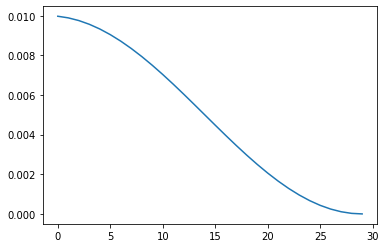

In [18]:
plt.plot(history['lr'])
plt.show()

<a id="inference"></a> 
# Inference

In [37]:
from crop_resize import read_parquets

height = 137
width = 236
image_size = 128

filenames = [in_dir/f'test_image_data_{i}.parquet' for i in range(4)]
images = read_parquets(filenames, width, height, image_size)
test_dataset = GraphemeDataset(images)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1480.34it/s]


In [38]:
row_id = []
target = []

model.eval()

with torch.no_grad():
    for idx, inputs in tqdm(enumerate(test_loader), total=len(test_loader)):
        outputs1, outputs2, outputs3 = model(inputs.float().cuda())
        p1 = outputs1.argmax(-1).view(-1).cpu()
        p2 = outputs2.argmax(-1).view(-1).cpu()
        p3 = outputs3.argmax(-1).view(-1).cpu()
        row_id += [f'Test_{idx}_grapheme_root', f'Test_{idx}_vowel_diacritic', f'Test_{idx}_consonant_diacritic']
        target += [p1.item(),p2.item(),p3.item()]

sub_df = pd.DataFrame({'row_id': row_id, 'target': target})
sub_df.to_csv(out_dir/'submission.csv', index=False)
sub_df

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,0
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2
5,Test_1_consonant_diacritic,0
6,Test_2_grapheme_root,19
7,Test_2_vowel_diacritic,0
8,Test_2_consonant_diacritic,0
9,Test_3_grapheme_root,115
